In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

In [2]:
sales_df = pd.read_csv('sales_data_sample.csv',encoding = 'unicode_escape')

In [3]:
sales_df

ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0           10107               30      95.70                2  2871.00   
1           10121               34      81.35                5  2765.90   
2           10134               41      94.74                2  3884.34   
3           10145               45      83.26                6  3746.70   
4           10159               49     100.00               14  5205.27   
...           ...              ...        ...              ...      ...   
2818        10350               20     100.00               15  2244.40   
2819        10373               29     100.00                1  3978.51   
2820        10386               43     100.00                4  5417.57   
2821        10397               34      62.24                1  2116.16   
2822        10414               47      65.52                9  3079.44   

            ORDERDATE    STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0      2/24/2003 0:00   Shipped       1         2     2003  ...   
1       5/7/2003 0:00   Shipped       2         5     2003  ...   
2       7/1/2003 0:00   Shipped       3         7     2003  ...   
3      8/25/2003 0:00   Shipped       3         8     2003  ...   
4     10/10/2003 0:00   Shipped       4        10     2003  ...   
...               ...       ...     ...       ...      ...  ...   
2818   12/2/2004 0:00   Shipped       4        12     2004  ...   
2819   1/31/2005 0:00   Shipped       1         1     2005  ...   
2820    3/1/2005 0:00  Resolved       1         3     2005  ...   
2821   3/28/2005 0:00   Shipped       1         3     2005  ...   
2822    5/6/2005 0:00   On Hold       2         5     2005  ...   

                       ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0           897 Long Airport Avenue           NaN            NYC    NY   
1                59 rue de l'Abbaye           NaN          Reims   NaN   
2     27 rue du Colonel Pierre Avia           NaN          Paris   NaN   
3                78934 Hillside Dr.           NaN       Pasadena    CA   
4                   7734 Strong St.           NaN  San Francisco    CA   
...                             ...           ...            ...   ...   
2818             C/ Moralzarzal, 86           NaN         Madrid   NaN   
2819                    Torikatu 38           NaN           Oulu   NaN   
2820             C/ Moralzarzal, 86           NaN         Madrid   NaN   
2821          1 rue Alsace-Lorraine           NaN       Toulouse   NaN   
2822             8616 Spinnaker Dr.           NaN         Boston    MA   

     POSTALCODE  COUNTRY TERRITORY CONTACTLASTNAME CONTACTFIRSTNAME DEALSIZE  
0         10022      USA       NaN              Yu             Kwai    Small  
1         51100   France      EMEA         Henriot             Paul    Small  
2         75508   France      EMEA        Da Cunha           Daniel   Medium  
3         90003      USA       NaN           Young            Julie   Medium  
4           NaN      USA       NaN           Brown            Julie   Medium  
...         ...      ...       ...             ...              ...      ...  
2818      28034    Spain      EMEA          Freyre            Diego    Small  
2819      90110  Finland      EMEA       Koskitalo           Pirkko   Medium  
2820      28034    Spain      EMEA          Freyre            Diego   Medium  
2821      31000   France      EMEA          Roulet          Annette    Small  
2822      51003      USA       NaN         Yoshido             Juri   Medium  

[2823 rows x 25 columns]

In [4]:
sales_df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [5]:
# Convert order date to datetime format
sales_df['ORDERDATE'] = pd.to_datetime(sales_df['ORDERDATE'])
# Check the type of data
sales_df.dtypes

ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
PHONE                       object
ADDRESSLINE1                object
ADDRESSLINE2                object
CITY                        object
STATE                       object
POSTALCODE                  object
COUNTRY                     object
TERRITORY                   object
CONTACTLASTNAME             object
CONTACTFIRSTNAME            object
DEALSIZE                    object
dtype: object

In [6]:
sales_df.info()
sales_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [7]:
# since there are lot of Null values in 'addressline2', 'state', 'postal code' and 'territory' we can drop them. 
# Country would represent the order grographical information.
# Also we can drop city, address1, phone number, contact_name, contact last_name and contact first_name since they are not required for the analysis

df_drop  = ['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df = sales_df.drop(df_drop, axis = 1)
sales_df.head()

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE   STATUS  \
0               30      95.70                2  2871.00 2003-02-24  Shipped   
1               34      81.35                5  2765.90 2003-05-07  Shipped   
2               41      94.74                2  3884.34 2003-07-01  Shipped   
3               45      83.26                6  3746.70 2003-08-25  Shipped   
4               49     100.00               14  5205.27 2003-10-10  Shipped   

   QTR_ID  MONTH_ID  YEAR_ID  PRODUCTLINE  MSRP PRODUCTCODE COUNTRY DEALSIZE  
0       1         2     2003  Motorcycles    95    S10_1678     USA    Small  
1       2         5     2003  Motorcycles    95    S10_1678  France    Small  
2       3         7     2003  Motorcycles    95    S10_1678  France   Medium  
3       3         8     2003  Motorcycles    95    S10_1678     USA   Medium  
4       4        10     2003  Motorcycles    95    S10_1678     USA   Medium

In [8]:
sales_df.isnull().sum()

QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
ORDERDATE          0
STATUS             0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
MSRP               0
PRODUCTCODE        0
COUNTRY            0
DEALSIZE           0
dtype: int64

In [9]:
sales_df.nunique()

QUANTITYORDERED      58
PRICEEACH          1016
ORDERLINENUMBER      18
SALES              2763
ORDERDATE           252
STATUS                6
QTR_ID                4
MONTH_ID             12
YEAR_ID               3
PRODUCTLINE           7
MSRP                 80
PRODUCTCODE         109
COUNTRY              19
DEALSIZE              3
dtype: int64

In [10]:
sales_df['COUNTRY'].value_counts().index

Index(['USA', 'Spain', 'France', 'Australia', 'UK', 'Italy', 'Finland',
       'Norway', 'Singapore', 'Canada', 'Denmark', 'Germany', 'Sweden',
       'Austria', 'Japan', 'Belgium', 'Switzerland', 'Philippines', 'Ireland'],
      dtype='object')

In [11]:
sales_df['COUNTRY'].value_counts()

USA            1004
Spain           342
France          314
Australia       185
UK              144
Italy           113
Finland          92
Norway           85
Singapore        79
Canada           70
Denmark          63
Germany          62
Sweden           57
Austria          55
Japan            52
Belgium          33
Switzerland      31
Philippines      26
Ireland          16
Name: COUNTRY, dtype: int64

In [12]:
# Function to visulize the count of items in a given column
# Note that Plotly is a Python graphing library that makes interactive, publication-quality graphs. 
# Note: px (plotly_express) is a high-level wrapper around plotly for rapid data exploration and figure generation


def barplot_visualization(x):
  fig = plt.Figure(figsize = (12, 6))
  fig = px.bar(x = sales_df[x].value_counts().index, y = sales_df[x].value_counts(), color = sales_df[x].value_counts().index, height = 600)
  fig.show()

In [13]:
barplot_visualization('COUNTRY')

In [14]:
barplot_visualization('STATUS')

In [15]:
sales_df.drop(columns= ['STATUS'], inplace = True)
sales_df

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0                  30      95.70                2  2871.00 2003-02-24       1   
1                  34      81.35                5  2765.90 2003-05-07       2   
2                  41      94.74                2  3884.34 2003-07-01       3   
3                  45      83.26                6  3746.70 2003-08-25       3   
4                  49     100.00               14  5205.27 2003-10-10       4   
...               ...        ...              ...      ...        ...     ...   
2818               20     100.00               15  2244.40 2004-12-02       4   
2819               29     100.00                1  3978.51 2005-01-31       1   
2820               43     100.00                4  5417.57 2005-03-01       1   
2821               34      62.24                1  2116.16 2005-03-28       1   
2822               47      65.52                9  3079.44 2005-05-06       2   

      MONTH_ID  YEAR_ID  PRODUCTLINE  MSRP PRODUCTCODE  COUNTRY DEALSIZE  
0            2     2003  Motorcycles    95    S10_1678      USA    Small  
1            5     2003  Motorcycles    95    S10_1678   France    Small  
2            7     2003  Motorcycles    95    S10_1678   France   Medium  
3            8     2003  Motorcycles    95    S10_1678      USA   Medium  
4           10     2003  Motorcycles    95    S10_1678      USA   Medium  
...        ...      ...          ...   ...         ...      ...      ...  
2818        12     2004        Ships    54    S72_3212    Spain    Small  
2819         1     2005        Ships    54    S72_3212  Finland   Medium  
2820         3     2005        Ships    54    S72_3212    Spain   Medium  
2821         3     2005        Ships    54    S72_3212   France    Small  
2822         5     2005        Ships    54    S72_3212      USA   Medium  

[2823 rows x 13 columns]

In [16]:
barplot_visualization('PRODUCTLINE')

In [17]:
barplot_visualization('DEALSIZE')

In [18]:
def dummies(x):
  dummy = pd.get_dummies(sales_df[x])
  sales_df.drop(columns = x , inplace = True)
  return pd.concat([sales_df, dummy], axis = 1)

In [19]:
sales_df = dummies('COUNTRY')
sales_df

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0                  30      95.70                2  2871.00 2003-02-24       1   
1                  34      81.35                5  2765.90 2003-05-07       2   
2                  41      94.74                2  3884.34 2003-07-01       3   
3                  45      83.26                6  3746.70 2003-08-25       3   
4                  49     100.00               14  5205.27 2003-10-10       4   
...               ...        ...              ...      ...        ...     ...   
2818               20     100.00               15  2244.40 2004-12-02       4   
2819               29     100.00                1  3978.51 2005-01-31       1   
2820               43     100.00                4  5417.57 2005-03-01       1   
2821               34      62.24                1  2116.16 2005-03-28       1   
2822               47      65.52                9  3079.44 2005-05-06       2   

      MONTH_ID  YEAR_ID  PRODUCTLINE  MSRP  ... Italy Japan  Norway  \
0            2     2003  Motorcycles    95  ...     0     0       0   
1            5     2003  Motorcycles    95  ...     0     0       0   
2            7     2003  Motorcycles    95  ...     0     0       0   
3            8     2003  Motorcycles    95  ...     0     0       0   
4           10     2003  Motorcycles    95  ...     0     0       0   
...        ...      ...          ...   ...  ...   ...   ...     ...   
2818        12     2004        Ships    54  ...     0     0       0   
2819         1     2005        Ships    54  ...     0     0       0   
2820         3     2005        Ships    54  ...     0     0       0   
2821         3     2005        Ships    54  ...     0     0       0   
2822         5     2005        Ships    54  ...     0     0       0   

      Philippines  Singapore  Spain  Sweden  Switzerland  UK  USA  
0               0          0      0       0            0   0    1  
1               0          0      0       0            0   0    0  
2               0          0      0       0            0   0    0  
3               0          0      0       0            0   0    1  
4               0          0      0       0            0   0    1  
...           ...        ...    ...     ...          ...  ..  ...  
2818            0          0      1       0            0   0    0  
2819            0          0      0       0            0   0    0  
2820            0          0      1       0            0   0    0  
2821            0          0      0       0            0   0    0  
2822            0          0      0       0            0   0    1  

[2823 rows x 31 columns]

In [20]:
sales_df = dummies('PRODUCTLINE')

In [21]:
sales_df

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0                  30      95.70                2  2871.00 2003-02-24       1   
1                  34      81.35                5  2765.90 2003-05-07       2   
2                  41      94.74                2  3884.34 2003-07-01       3   
3                  45      83.26                6  3746.70 2003-08-25       3   
4                  49     100.00               14  5205.27 2003-10-10       4   
...               ...        ...              ...      ...        ...     ...   
2818               20     100.00               15  2244.40 2004-12-02       4   
2819               29     100.00                1  3978.51 2005-01-31       1   
2820               43     100.00                4  5417.57 2005-03-01       1   
2821               34      62.24                1  2116.16 2005-03-28       1   
2822               47      65.52                9  3079.44 2005-05-06       2   

      MONTH_ID  YEAR_ID  MSRP PRODUCTCODE  ... Switzerland  UK  USA  \
0            2     2003    95    S10_1678  ...           0   0    1   
1            5     2003    95    S10_1678  ...           0   0    0   
2            7     2003    95    S10_1678  ...           0   0    0   
3            8     2003    95    S10_1678  ...           0   0    1   
4           10     2003    95    S10_1678  ...           0   0    1   
...        ...      ...   ...         ...  ...         ...  ..  ...   
2818        12     2004    54    S72_3212  ...           0   0    0   
2819         1     2005    54    S72_3212  ...           0   0    0   
2820         3     2005    54    S72_3212  ...           0   0    0   
2821         3     2005    54    S72_3212  ...           0   0    0   
2822         5     2005    54    S72_3212  ...           0   0    1   

      Classic Cars  Motorcycles  Planes  Ships  Trains  Trucks and Buses  \
0                0            1       0      0       0                 0   
1                0            1       0      0       0                 0   
2                0            1       0      0       0                 0   
3                0            1       0      0       0                 0   
4                0            1       0      0       0                 0   
...            ...          ...     ...    ...     ...               ...   
2818             0            0       0      1       0                 0   
2819             0            0       0      1       0                 0   
2820             0            0       0      1       0                 0   
2821             0            0       0      1       0                 0   
2822             0            0       0      1       0                 0   

      Vintage Cars  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
2818             0  
2819             0  
2820             0  
2821             0  
2822             0  

[2823 rows x 37 columns]

In [22]:
sales_df = dummies('DEALSIZE')
sales_df

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0                  30      95.70                2  2871.00 2003-02-24       1   
1                  34      81.35                5  2765.90 2003-05-07       2   
2                  41      94.74                2  3884.34 2003-07-01       3   
3                  45      83.26                6  3746.70 2003-08-25       3   
4                  49     100.00               14  5205.27 2003-10-10       4   
...               ...        ...              ...      ...        ...     ...   
2818               20     100.00               15  2244.40 2004-12-02       4   
2819               29     100.00                1  3978.51 2005-01-31       1   
2820               43     100.00                4  5417.57 2005-03-01       1   
2821               34      62.24                1  2116.16 2005-03-28       1   
2822               47      65.52                9  3079.44 2005-05-06       2   

      MONTH_ID  YEAR_ID  MSRP PRODUCTCODE  ...  Classic Cars  Motorcycles  \
0            2     2003    95    S10_1678  ...             0            1   
1            5     2003    95    S10_1678  ...             0            1   
2            7     2003    95    S10_1678  ...             0            1   
3            8     2003    95    S10_1678  ...             0            1   
4           10     2003    95    S10_1678  ...             0            1   
...        ...      ...   ...         ...  ...           ...          ...   
2818        12     2004    54    S72_3212  ...             0            0   
2819         1     2005    54    S72_3212  ...             0            0   
2820         3     2005    54    S72_3212  ...             0            0   
2821         3     2005    54    S72_3212  ...             0            0   
2822         5     2005    54    S72_3212  ...             0            0   

      Planes  Ships  Trains  Trucks and Buses  Vintage Cars  Large  Medium  \
0          0      0       0                 0             0      0       0   
1          0      0       0                 0             0      0       0   
2          0      0       0                 0             0      0       1   
3          0      0       0                 0             0      0       1   
4          0      0       0                 0             0      0       1   
...      ...    ...     ...               ...           ...    ...     ...   
2818       0      1       0                 0             0      0       0   
2819       0      1       0                 0             0      0       1   
2820       0      1       0                 0             0      0       1   
2821       0      1       0                 0             0      0       0   
2822       0      1       0                 0             0      0       1   

      Small  
0         1  
1         1  
2         0  
3         0  
4         0  
...     ...  
2818      1  
2819      0  
2820      0  
2821      1  
2822      0  

[2823 rows x 39 columns]

In [23]:
y = pd.Categorical(sales_df['PRODUCTCODE'])
y

['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962', 'S700_4002', 'S72_1253', 'S72_3212']

In [24]:
y = pd.Categorical(sales_df['PRODUCTCODE']).codes
y

array([  0,   0,   0, ..., 108, 108, 108], dtype=int8)

In [25]:
# Since the number unique product code is 109, if we add one-hot variables, there 
# would be additional 109 columns, we can avoid that by using categorical encoding
# This is not the optimal way of dealing with it but it's important to avoid curse of dimensionality
sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes

In [26]:
sales_df

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0                  30      95.70                2  2871.00 2003-02-24       1   
1                  34      81.35                5  2765.90 2003-05-07       2   
2                  41      94.74                2  3884.34 2003-07-01       3   
3                  45      83.26                6  3746.70 2003-08-25       3   
4                  49     100.00               14  5205.27 2003-10-10       4   
...               ...        ...              ...      ...        ...     ...   
2818               20     100.00               15  2244.40 2004-12-02       4   
2819               29     100.00                1  3978.51 2005-01-31       1   
2820               43     100.00                4  5417.57 2005-03-01       1   
2821               34      62.24                1  2116.16 2005-03-28       1   
2822               47      65.52                9  3079.44 2005-05-06       2   

      MONTH_ID  YEAR_ID  MSRP  PRODUCTCODE  ...  Classic Cars  Motorcycles  \
0            2     2003    95            0  ...             0            1   
1            5     2003    95            0  ...             0            1   
2            7     2003    95            0  ...             0            1   
3            8     2003    95            0  ...             0            1   
4           10     2003    95            0  ...             0            1   
...        ...      ...   ...          ...  ...           ...          ...   
2818        12     2004    54          108  ...             0            0   
2819         1     2005    54          108  ...             0            0   
2820         3     2005    54          108  ...             0            0   
2821         3     2005    54          108  ...             0            0   
2822         5     2005    54          108  ...             0            0   

      Planes  Ships  Trains  Trucks and Buses  Vintage Cars  Large  Medium  \
0          0      0       0                 0             0      0       0   
1          0      0       0                 0             0      0       0   
2          0      0       0                 0             0      0       1   
3          0      0       0                 0             0      0       1   
4          0      0       0                 0             0      0       1   
...      ...    ...     ...               ...           ...    ...     ...   
2818       0      1       0                 0             0      0       0   
2819       0      1       0                 0             0      0       1   
2820       0      1       0                 0             0      0       1   
2821       0      1       0                 0             0      0       0   
2822       0      1       0                 0             0      0       1   

      Small  
0         1  
1         1  
2         0  
3         0  
4         0  
...     ...  
2818      1  
2819      0  
2820      0  
2821      1  
2822      0  

[2823 rows x 39 columns]

In [27]:
# Group data by order date
sales_df_group = sales_df.groupby(by = "ORDERDATE").sum()
sales_df_group

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER     SALES  QTR_ID  \
ORDERDATE                                                                   
2003-01-06              151     288.78               10  12133.25       4   
2003-01-09              142     284.96               10  11432.34       4   
2003-01-10               80     150.14                3   6864.05       2   
2003-01-29              541    1417.54              136  54702.00      16   
2003-01-31              443    1061.89               91  44621.96      13   
...                     ...        ...              ...       ...     ...   
2005-05-13              259     561.18               21  31821.90      12   
2005-05-17              509    1269.43              105  59475.10      28   
2005-05-29              607    1148.40               94  51233.18      30   
2005-05-30              187     542.16               18  14578.75      14   
2005-05-31              696    1561.40              112  78918.03      38   

            MONTH_ID  YEAR_ID  MSRP  PRODUCTCODE  Australia  ...  \
ORDERDATE                                                    ...   
2003-01-06         4     8012   363          174          0  ...   
2003-01-09         4     8012   372          181          0  ...   
2003-01-10         2     4006   155           37          0  ...   
2003-01-29        16    32048  1695          723          0  ...   
2003-01-31        13    26039  1365          720          0  ...   
...              ...      ...   ...          ...        ...  ...   
2005-05-13        30    12030   728          101          0  ...   
2005-05-17        70    28070  1669          462          0  ...   
2005-05-29        75    30075  1328          797         13  ...   
2005-05-30        35    14035   618          265          0  ...   
2005-05-31        95    38095  2065          899          0  ...   

            Classic Cars  Motorcycles  Planes  Ships  Trains  \
ORDERDATE                                                      
2003-01-06             0            0       0      0       0   
2003-01-09             0            0       0      0       0   
2003-01-10             0            0       0      0       0   
2003-01-29             3            0       0      0       0   
2003-01-31             7            0       0      0       2   
...                  ...          ...     ...    ...     ...   
2005-05-13             0            6       0      0       0   
2005-05-17            14            0       0      0       0   
2005-05-29             7            0       0      0       0   
2005-05-30             0            0       0      0       0   
2005-05-31             7            0       0      0       0   

            Trucks and Buses  Vintage Cars  Large  Medium  Small  
ORDERDATE                                                         
2003-01-06                 0             4      0       2      2  
2003-01-09                 0             4      0       2      2  
2003-01-10                 0             2      0       1      1  
2003-01-29                 7             6      0      10      6  
2003-01-31                 4             0      0       8      5  
...                      ...           ...    ...     ...    ...  
2005-05-13                 0             0      2       3      1  
2005-05-17                 0             0      2       8      4  
2005-05-29                 0             8      0       8      7  
2005-05-30                 0             7      0       1      6  
2005-05-31                11             1      3       9      7  

[252 rows x 38 columns]

In [28]:
fig = px.line(x = sales_df_group.index, y = sales_df_group.SALES, title = 'Sales')
fig.show()

In [29]:
# We can drop 'ORDERDATE' and keep the rest of the date-related data such as 'MONTH'
sales_df.drop("ORDERDATE", axis = 1, inplace = True)
sales_df.shape

(2823, 38)

<Axes: >

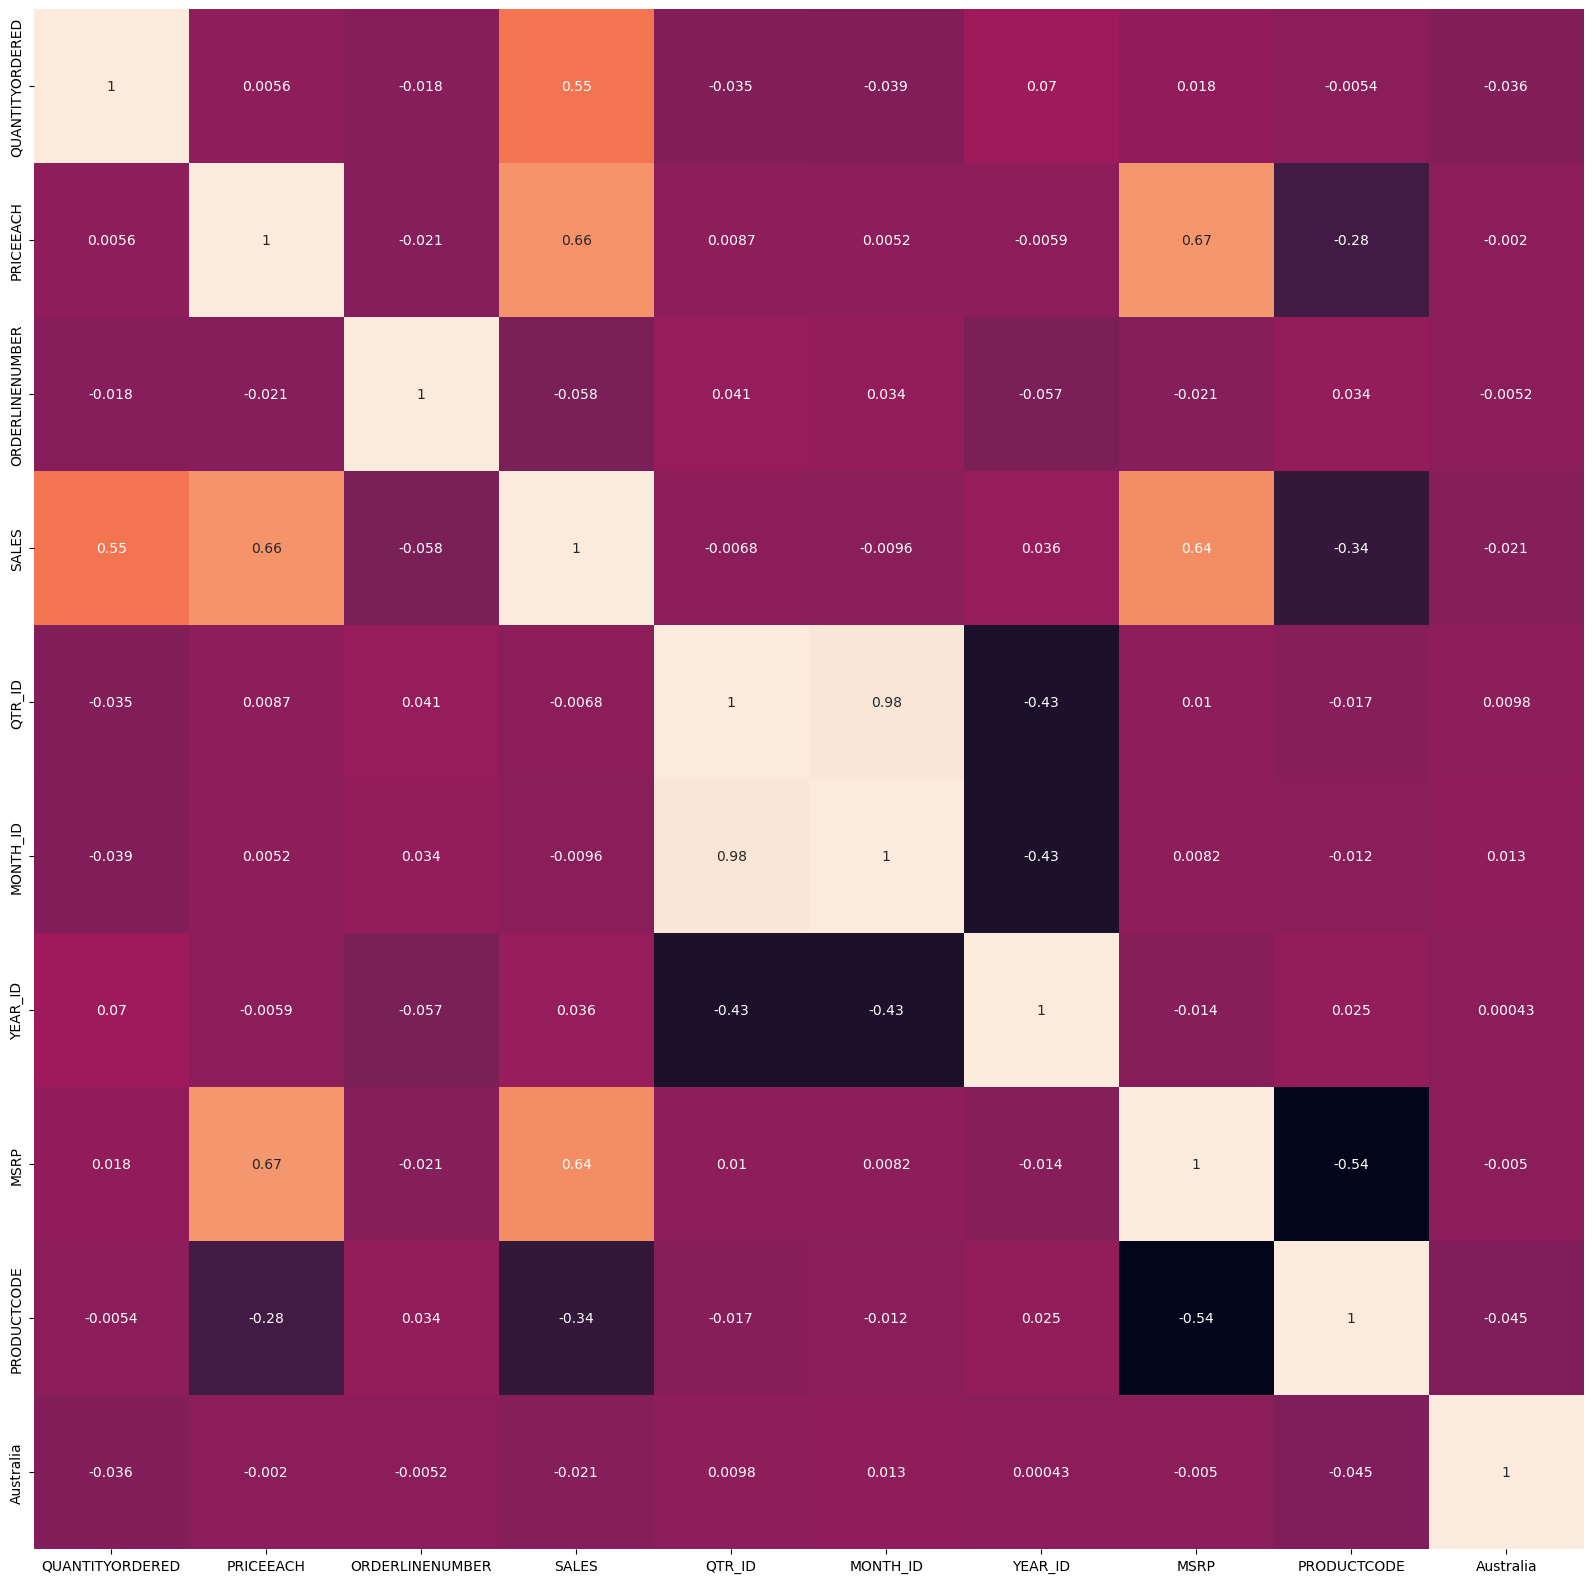

In [30]:
plt.figure(figsize = (20, 20))
corr_matrix = sales_df.iloc[:, :10].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)

In [31]:
# It looks like the Quarter ID and the monthly IDs are highly correlated
# Let's drop 'QTR_ID' (or 'MONTH_ID') 
sales_df.drop("QTR_ID", axis = 1, inplace = True)
sales_df.shape

(2823, 37)

In [32]:
# Let's plot distplots
# Distplot shows the (1) histogram, (2) kde plot and (3) rug plot.
# (1) Histogram: it's a graphical display of data using bars with various heights. Each bar groups numbers into ranges and taller bars show that more data falls in that range.
# (2) Kde Plot: Kernel Density Estimate is used for visualizing the Probability Density of a continuous variable.
# (3) Rug plot: plot of data for a single quantitative variable, displayed as marks along an axis (one-dimensional scatter plot). 

import plotly.figure_factory as ff

plt.figure(figsize = (10, 10))

for i in range(8):
  if sales_df.columns[i] != 'ORDERLINENUMBER':
    fig = ff.create_distplot([sales_df[sales_df.columns[i]].apply(lambda x: float(x))], ['distplot'])
    fig.update_layout(title_text = sales_df.columns[i])
    fig.show()

C:\Users\sefak\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning:

Blowfish has been deprecated



<Figure size 1000x1000 with 0 Axes>

In [33]:
# Visualize the relationship between variables using pairplots
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(sales_df,
    dimensions = sales_df.columns[:8], color = 'MONTH_ID')

fig.update_layout(
    title = 'Sales Data',
    width = 1100,
    height = 1100,
)
fig.show()

# A trend exists between 'SALES' and 'QUANTITYORDERED'  
# A trend exists between 'MSRP' and 'PRICEEACH'  
# A trend exists between 'PRICEEACH' and 'SALES'
# It seems that sales growth exists as we move from 2013 to 2014 to 2015 ('SALES' vs. 'YEAR_ID')
# zoom in into 'SALES' and 'QUANTITYORDERED', you will be able to see the monthly information color coded on the graph

C:\Users\sefak\anaconda3\Lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



<Figure size 1500x1500 with 0 Axes>

In [34]:
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)

In [35]:
sales_df_scaled.shape

(2823, 37)

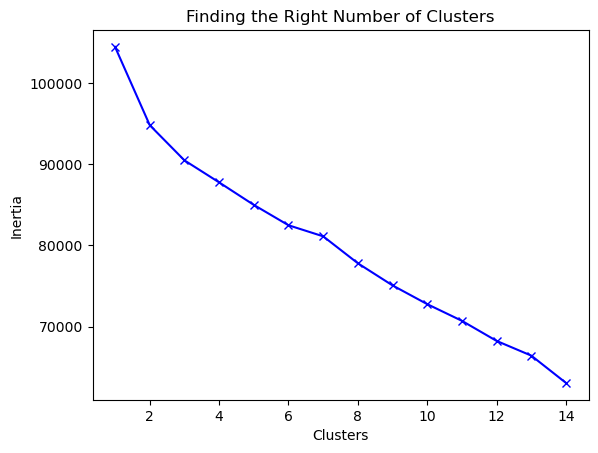

In [36]:
scores = []
range_values = range(1, 15)

for i in range_values:
    kmeans = KMeans(n_clusters=i, n_init=10)  # Explicitly setting n_init to suppress the warning
    kmeans.fit(sales_df_scaled)
    scores.append(kmeans.inertia_)  # inertia is the Sum of squared distances of samples to their closest cluster center

plt.plot(range_values, scores, 'bx-')  # Use range_values for x-axis
plt.title('Finding the Right Number of Clusters')
plt.xlabel('Clusters')
plt.ylabel('Inertia')  # You might want to label it as Inertia instead of scores
plt.show()

In [37]:
kmeans = KMeans(5, n_init=10)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_
#labels > Specifies a cluster number for each data point in this situation

In [38]:
labels

array([1, 1, 3, ..., 2, 2, 2])

In [39]:
kmeans.cluster_centers_.shape

(5, 37)

In [40]:
# Let's take a look at the cluster centers 
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers 

QUANTITYORDERED PRICEEACH ORDERLINENUMBER     SALES  MONTH_ID   YEAR_ID  \
0        1.248866  0.800157       -0.257501  2.576679 -0.095423  0.145203   
1       -0.449823 -0.817387        0.017203 -0.836977  0.035681 -0.017771   
2       -0.085462 -0.100859        0.155991 -0.346841 -0.073142  0.093811   
3        0.244054  0.626557       -0.047287  0.508781  0.020692 -0.024036   
4        0.191867 -0.057456       -0.010199  0.033722 -0.277772 -0.945247   

       MSRP PRODUCTCODE Australia   Austria  ... Classic Cars Motorcycles  \
0  1.430454   -0.870738 -0.083492  0.044555  ...     0.588443    0.014123   
1 -0.595005    0.054775  0.057469 -0.037390  ...     0.004293    0.115460   
2 -0.404233    1.042711 -0.055940 -0.011505  ...    -0.721812   -0.364452   
3  0.486099   -0.382885 -0.007031  0.033680  ...     0.222801    0.048202   
4 -0.068541    0.074165 -0.264819 -0.140961  ...     0.331795    0.472398   

     Planes     Ships    Trains Trucks and Buses Vintage Cars     Large  \
0 -0.183715 -0.300637 -0.128100        -0.200082    -0.148900  4.120788   
1 -0.348674 -0.300637  0.146414         0.048772     0.275539 -0.242672   
2  1.390766  1.365003 -0.167454        -0.345470    -0.523371 -0.242672   
3 -0.290441 -0.291257 -0.029850         0.143334     0.024293 -0.242672   
4  0.269920 -0.300637 -0.167454        -0.345470    -0.429753 -0.074847   

     Medium     Small  
0 -0.980703 -0.912100  
1 -0.980703  1.096370  
2 -0.145555  0.257844  
3  1.019676 -0.912100  
4  0.096424 -0.062363  

[5 rows x 37 columns]

In [41]:
# In order to understand what these numbers mean, let's perform inverse transformation
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers



QUANTITYORDERED  PRICEEACH ORDERLINENUMBER        SALES  MONTH_ID  \
0       47.256410  99.798269        5.378205  8298.944103  6.743590   
1       30.711656  67.171278        6.538855  2012.562914  7.222904   
2       34.260437  81.624155        7.125249  2915.167078  6.825050   
3       37.469828  96.296629        6.266379  4490.829543  7.168103   
4       36.961538  82.499615        6.423077  3615.989615  6.076923   

       YEAR_ID        MSRP PRODUCTCODE     Australia       Austria  ...  \
0  2003.916667  158.192308   26.275641  4.487179e-02  2.564103e-02  ...   
1  2003.802658   76.807771   55.503067  7.975460e-02  1.431493e-02  ...   
2  2003.880716   84.473161   86.701789  5.168986e-02  1.789264e-02  ...   
3  2003.798276  120.247414   41.681897  6.379310e-02  2.413793e-02  ...   
4  2003.153846   97.961538   56.115385  1.387779e-17 -3.469447e-18  ...   

   Classic Cars   Motorcycles        Planes         Ships        Trains  \
0  6.217949e-01  1.217949e-01  5.128205e-02 -5.551115e-17  6.410256e-03   
1  3.445808e-01  1.543967e-01 -1.249001e-16  4.302114e-16  5.112474e-02   
2 -6.661338e-16 -5.967449e-16  5.407555e-01  4.592445e-01 -1.006140e-16   
3  4.482759e-01  1.327586e-01  1.810345e-02  2.586207e-03  2.241379e-02   
4  5.000000e-01  2.692308e-01  1.923077e-01 -1.387779e-17  0.000000e+00   

  Trucks and Buses  Vintage Cars         Large        Medium         Small  
0     4.487179e-02  1.538462e-01  1.000000e+00 -4.440892e-16  4.996004e-16  
1     1.216769e-01  3.282209e-01  7.632783e-17 -9.992007e-16  1.000000e+00  
2    -2.498002e-16 -4.996004e-16  6.938894e-17  4.174950e-01  5.825050e-01  
3     1.508621e-01  2.250000e-01  2.012279e-16  1.000000e+00  1.720846e-15  
4    -1.387779e-17  3.846154e-02  3.846154e-02  5.384615e-01  4.230769e-01  

[5 rows x 37 columns]

In [42]:
labels.shape # Labels associated to each data point

(2823,)

In [43]:
labels.max()

4

In [44]:
y_kmeans = kmeans.fit_predict(sales_df_scaled)
y_kmeans


array([1, 1, 1, ..., 3, 2, 3])

In [45]:
y_kmeans.shape

(2823,)

In [46]:
# Add a label (which cluster) corresponding to each data point
sale_df_cluster = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
sale_df_cluster

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  MONTH_ID  YEAR_ID  \
0                  30      95.70                2  2871.00         2     2003   
1                  34      81.35                5  2765.90         5     2003   
2                  41      94.74                2  3884.34         7     2003   
3                  45      83.26                6  3746.70         8     2003   
4                  49     100.00               14  5205.27        10     2003   
...               ...        ...              ...      ...       ...      ...   
2818               20     100.00               15  2244.40        12     2004   
2819               29     100.00                1  3978.51         1     2005   
2820               43     100.00                4  5417.57         3     2005   
2821               34      62.24                1  2116.16         3     2005   
2822               47      65.52                9  3079.44         5     2005   

      MSRP  PRODUCTCODE  Australia  Austria  ...  Motorcycles  Planes  Ships  \
0       95            0          0        0  ...            1       0      0   
1       95            0          0        0  ...            1       0      0   
2       95            0          0        0  ...            1       0      0   
3       95            0          0        0  ...            1       0      0   
4       95            0          0        0  ...            1       0      0   
...    ...          ...        ...      ...  ...          ...     ...    ...   
2818    54          108          0        0  ...            0       0      1   
2819    54          108          0        0  ...            0       0      1   
2820    54          108          0        0  ...            0       0      1   
2821    54          108          0        0  ...            0       0      1   
2822    54          108          0        0  ...            0       0      1   

      Trains  Trucks and Buses  Vintage Cars  Large  Medium  Small  cluster  
0          0                 0             0      0       0      1        1  
1          0                 0             0      0       0      1        1  
2          0                 0             0      0       1      0        3  
3          0                 0             0      0       1      0        3  
4          0                 0             0      0       1      0        3  
...      ...               ...           ...    ...     ...    ...      ...  
2818       0                 0             0      0       0      1        2  
2819       0                 0             0      0       1      0        2  
2820       0                 0             0      0       1      0        2  
2821       0                 0             0      0       0      1        2  
2822       0                 0             0      0       1      0        2  

[2823 rows x 38 columns]

In [47]:
sales_df['ORDERLINENUMBER'] = sales_df['ORDERLINENUMBER'].apply(lambda x: float(x))

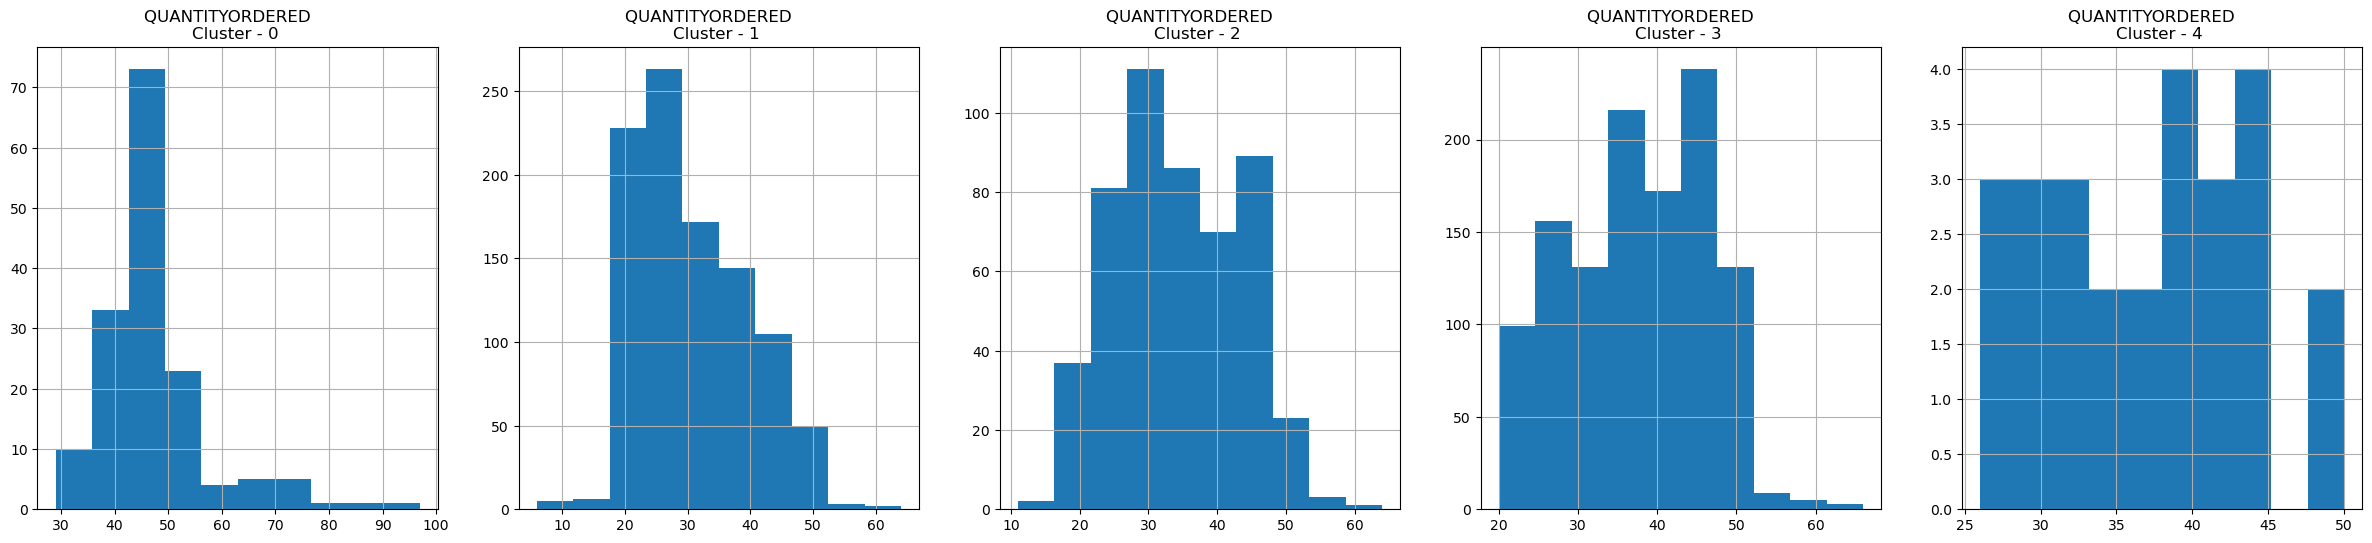

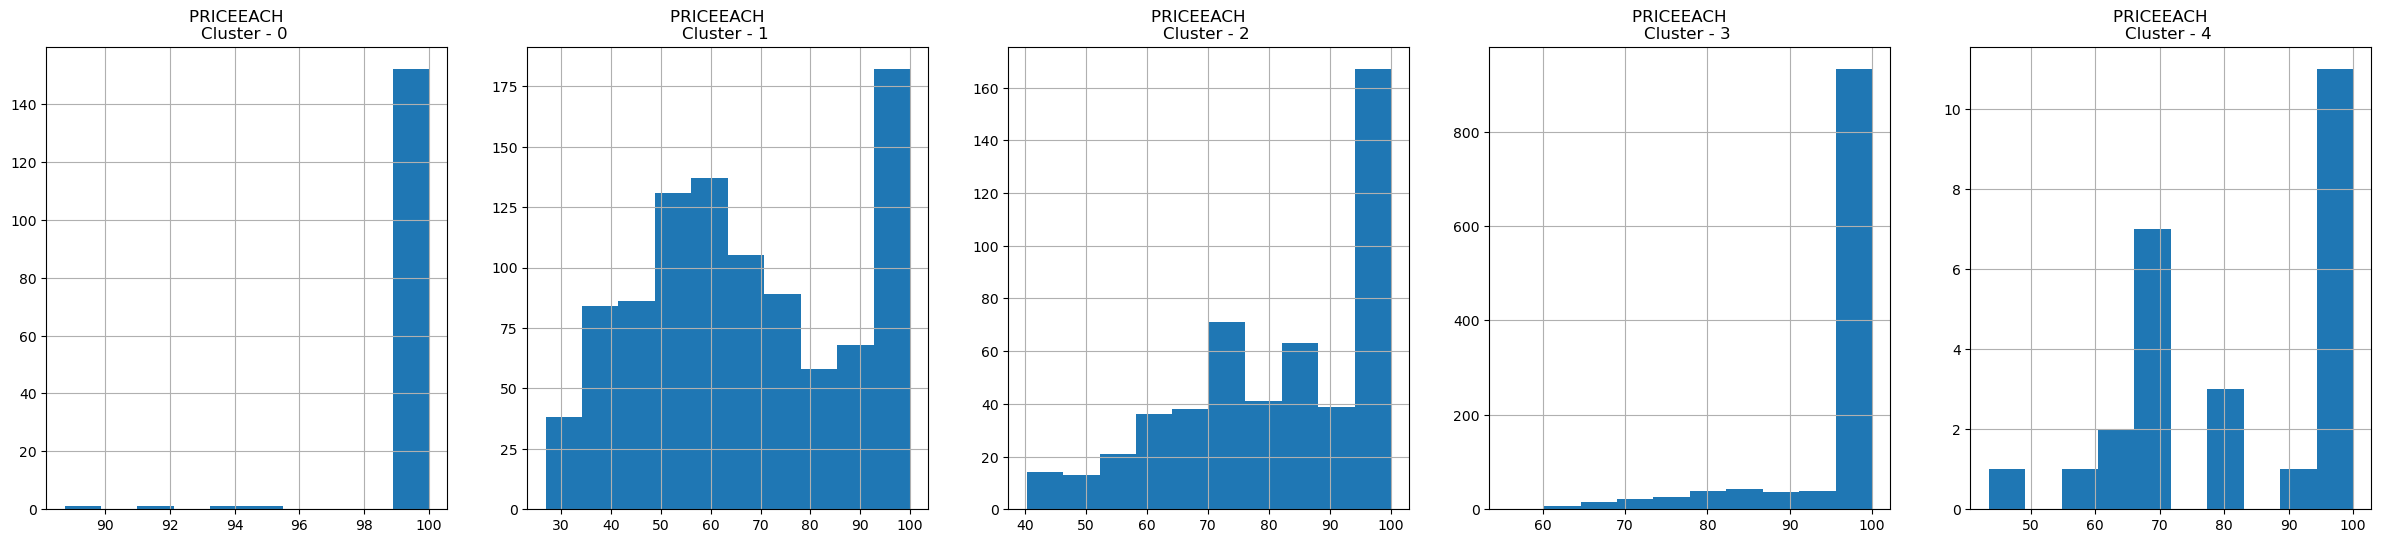

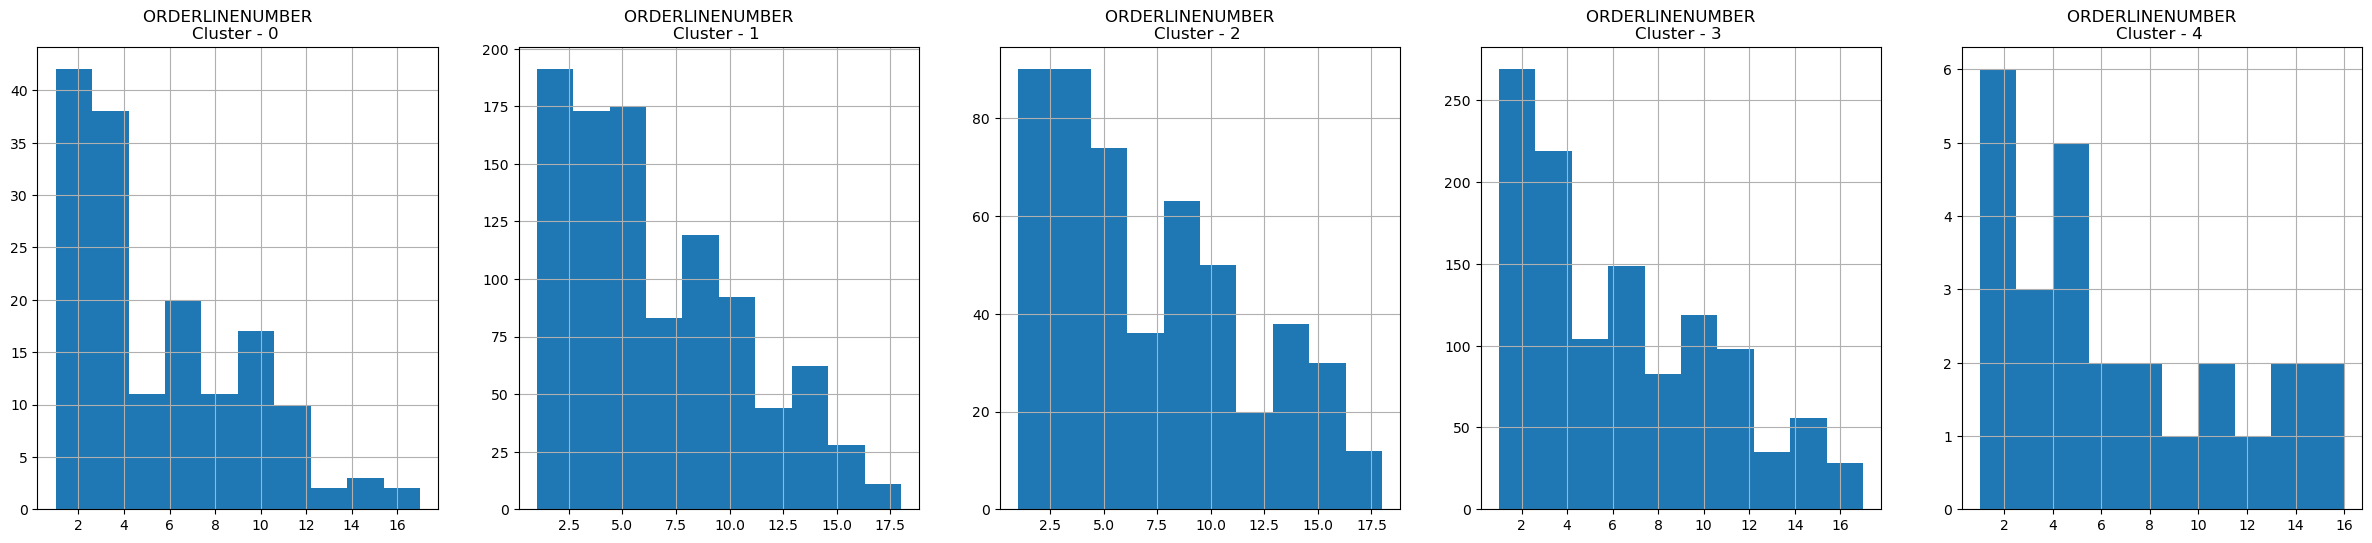

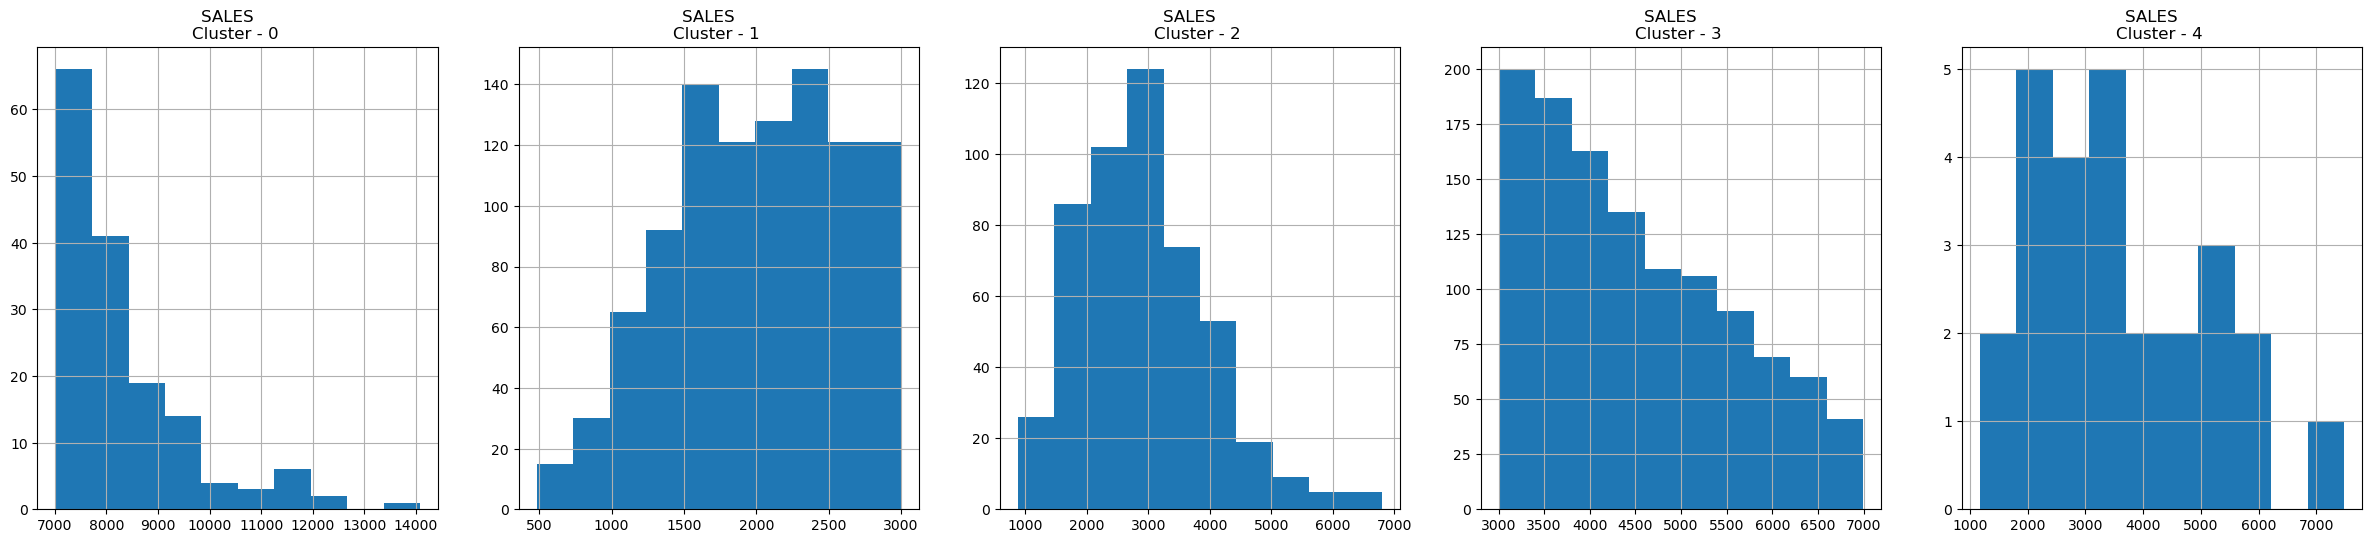

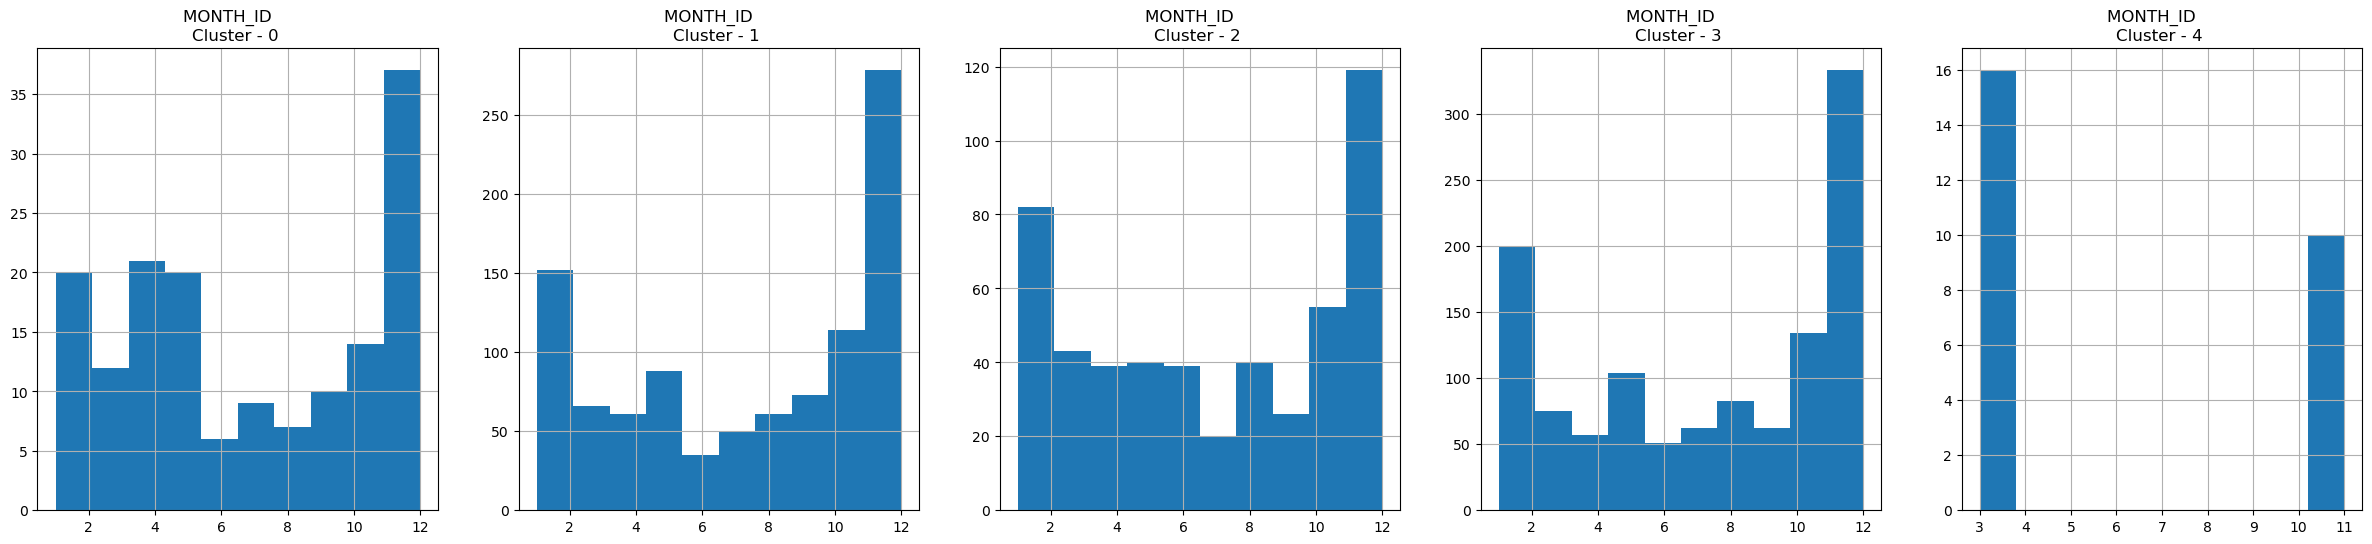

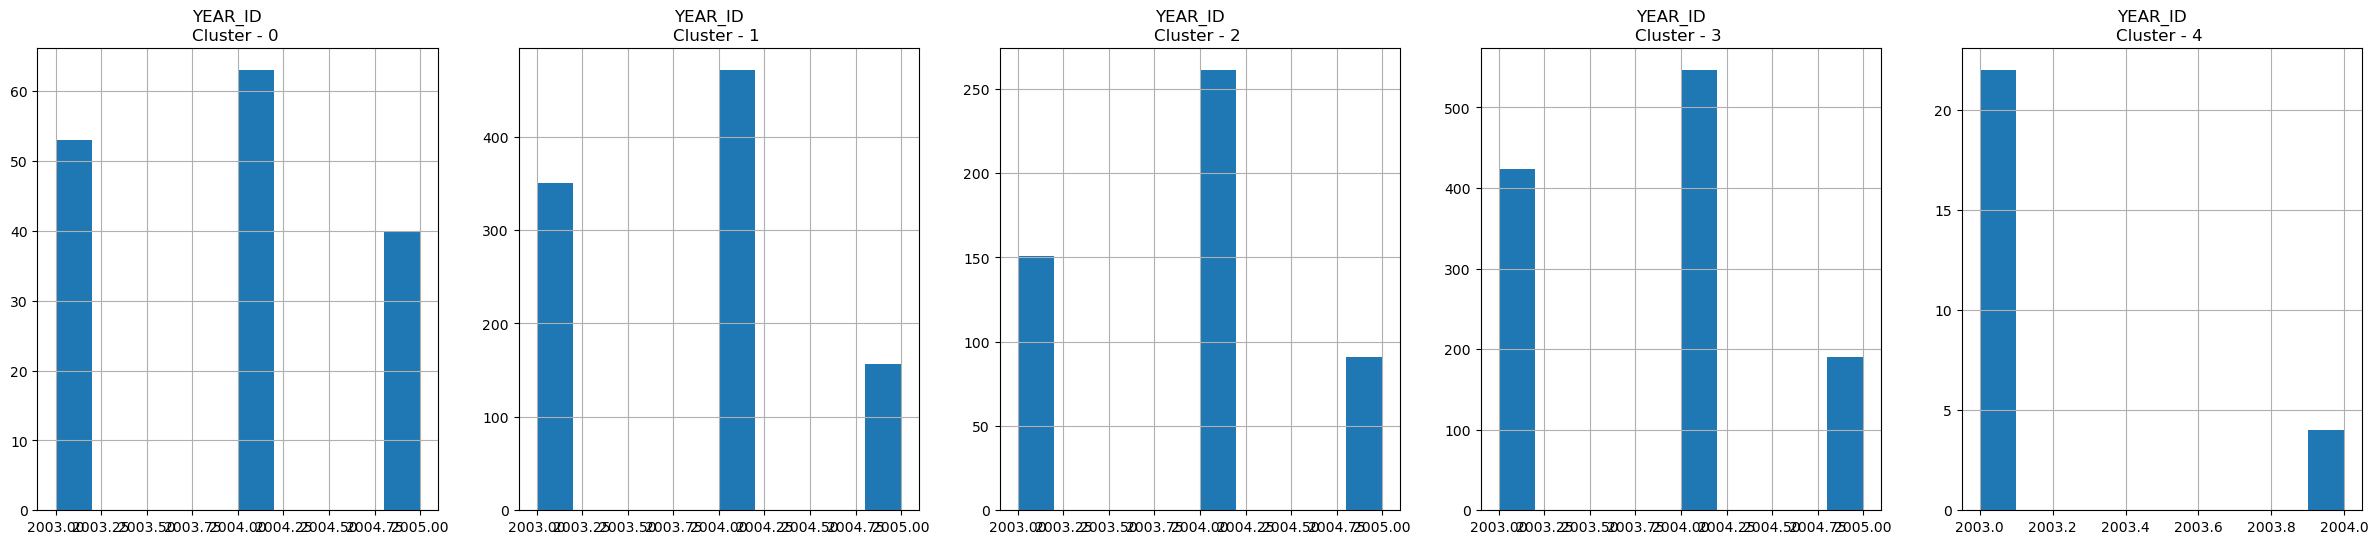

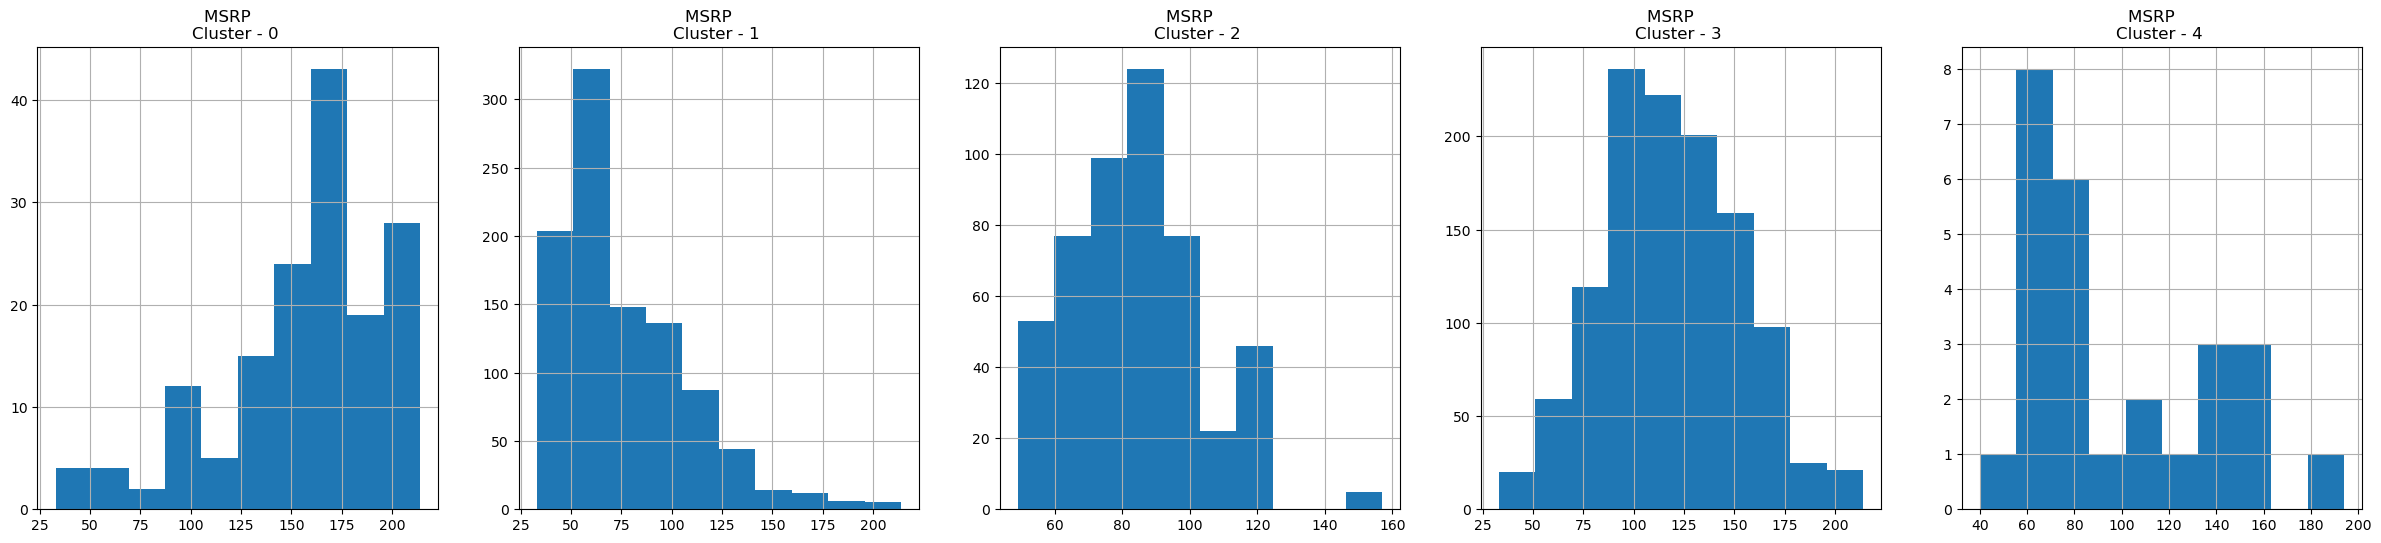

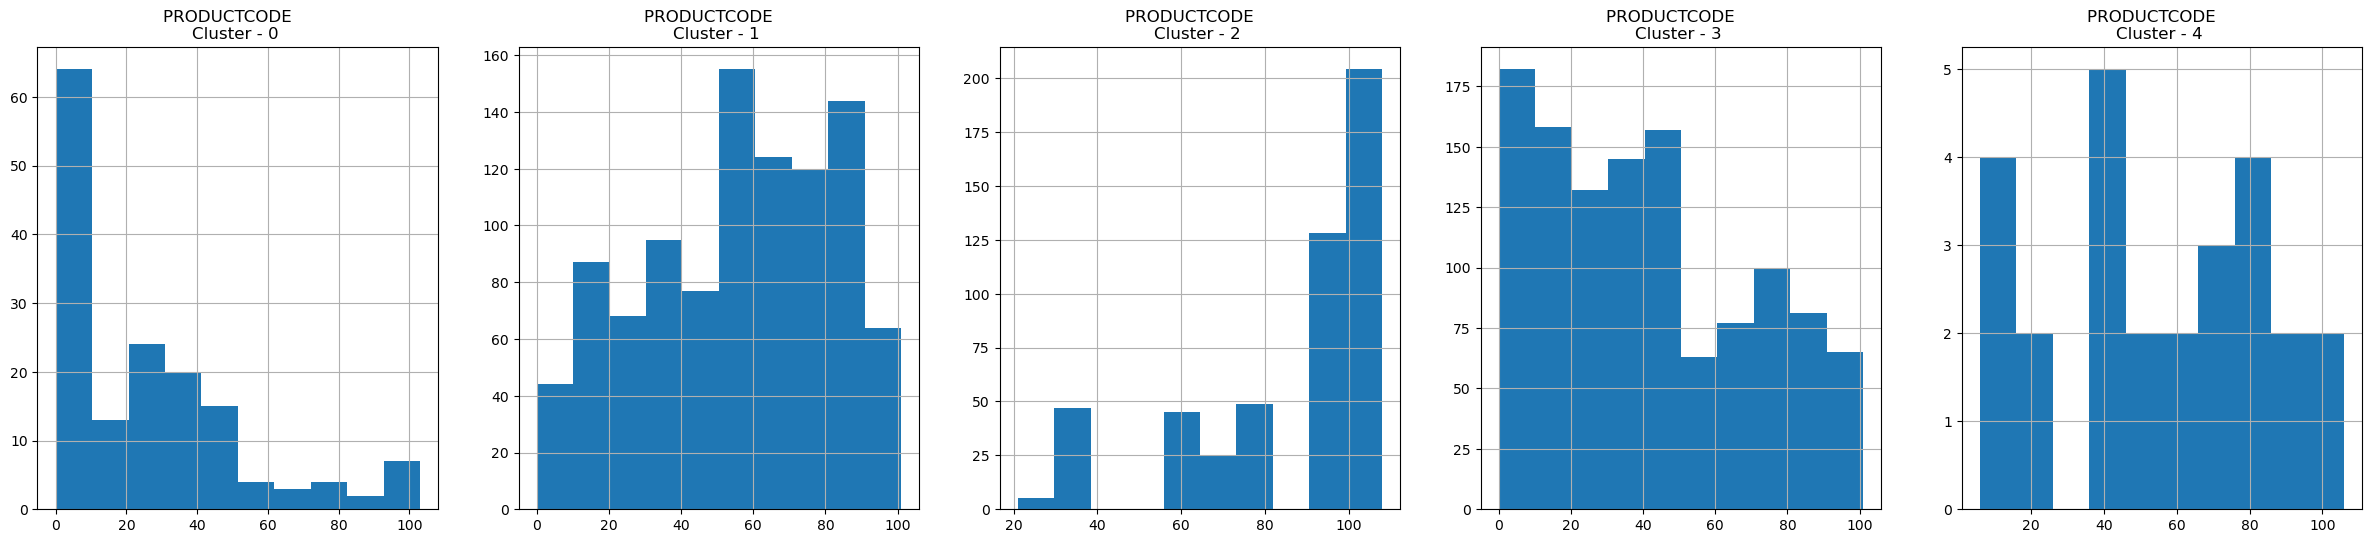

In [48]:
# plot histogram for each feature based on cluster 
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(5):
    plt.subplot(1, 5, j+1)
    cluster = sale_df_cluster[sale_df_cluster['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))
  
  plt.show()

In [49]:
# Reduce the original data to 3 dimensions using PCA for visualizig the clusters
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(sales_df_scaled)
principal_comp

array([[-0.4863027 , -1.24298694,  1.05446348],
       [-0.78452412, -1.07592959,  1.44514459],
       [ 1.43155021,  0.0362688 ,  0.29599636],
       ...,
       [ 0.39003661,  4.18061632, -0.15409199],
       [-2.78886323,  2.40601212,  1.52071401],
       [-0.70542012,  3.3643683 , -0.59015886]])

In [54]:
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

pca1      pca2      pca3
0 -0.486303 -1.242987  1.054463
1 -0.784524 -1.075930  1.445145
2  1.431550  0.036269  0.295996
3  1.288502 -0.273095 -0.569433
4  1.976218 -0.160627 -1.073382

In [55]:
# Concatenate the clusters labels to the dataframe
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df

pca1      pca2      pca3  cluster
0    -0.486303 -1.242987  1.054463        1
1    -0.784524 -1.075930  1.445145        1
2     1.431550  0.036269  0.295996        3
3     1.288502 -0.273095 -0.569433        3
4     1.976218 -0.160627 -1.073382        3
...        ...       ...       ...      ...
2818 -2.449979  1.199102 -1.595240        2
2819 -0.158517  3.622736  0.628826        2
2820  0.390037  4.180616 -0.154092        2
2821 -2.788863  2.406012  1.520714        2
2822 -0.705420  3.364368 -0.590159        2

[2823 rows x 4 columns]

In [56]:
# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3', 
              color = 'cluster', symbol = 'cluster', size_max = 18, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))